# Deep Learning for NLP - Project

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [63]:
from typing import List

class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.word2vec = self.load_wordvec(fname, nmax)
        self.word2id = {word: i for i, word in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(word2vec)))
        return word2vec
    
    def most_similar(self, w: str, K:int =5) -> List:
        """Given a word, returns the K words most similar to that word"""
        v = self.embeddings[self.word2id[w]]
        most_similar = []
        most_similar_indexes = np.argsort(self._score(v, self.embeddings))[::-1][1:K+1]
        for index in most_similar_indexes:
            most_similar.append(self.id2word[index])
        # K most similar words: self.score  -  np.argsort 
        return most_similar

    def score(self, w1: str, w2: str) -> np.float:
        """ Given two words, returns the cosine similarity between their representation in word2vec"""
        v1 = self.embeddings[self.word2id[w1]]
        v2 = self.embeddings[self.word2id[w2]]
        return self._score(v1, v2)
    
    def _score(self, v1: np.ndarray, v2: np.ndarray) -> np.float:
        """Given two np.ndarray of the same size returns the cosine similarity"""
        # cosine similarity: np.dot  -  np.linalg.norm
        if v1.ndim == 1 and v2.ndim == 1:
            return np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
        else:
            if v1.ndim == 1:
                v1 = v1.reshape((1,-1))
            return (np.dot(v1, v2.T) / ((np.linalg.norm(v1, axis=1)*np.linalg.norm(v2, axis=1)) + 1e-12)).reshape((-1))

In [64]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=1e5)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'london', 'berlin', 'tokyo']
['austria', 'europe', 'german', 'berlin', 'poland']


In [67]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
        
    def encode(self, sentences, idf=None):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for i,sent in enumerate(sentences):
            emb = []
            sum_weight = 0
            for word in sent.split():
                # we are not sure that every words are in word2vec
                if word in w2v.word2vec:
                    vector = self.w2v.word2vec[word]
                    if idf is not None and word in idf:
                        weight = idf[word]
                    else:
                        weight = 1
                    sum_weight += weight
                    vector = vector*weight
                    emb.append(vector)
            if len(emb) > 0:
                sentemb.append(np.sum(emb, axis=0)/sum_weight)
            else:
                sentemb.append(np.zeros((1,300)))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=None, K=5):
        # get most similar sentences and **print** them
        vector = self.encode([s], idf)
        sentences_vectors = self.encode(sentences, idf) 
        most_similar = []
        most_similar_indexes = np.argsort(self.w2v._score(vector, sentences_vectors))[::-1][1:K+1]
        for index in most_similar_indexes:
            most_similar.append(sentences[index])
        # K most similar words: self.score  -  np.argsort 
        return most_similar

    def score(self, s1, s2, idf=None):
        if isinstance(s1, str):
            s1 = self.encode([s1], idf)
        if isinstance(s2, str):
            s2 = self.encode([s2], idf)
        return self.w2v._score(s1, s2)
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
             for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        
        for word in idf:
            idf[word] = max(1, np.log10(len(sentences) / idf[word]))
        return idf


In [71]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    sentences = f.readlines()
sentences = [sentence.replace('\n', '') for sentence in sentences]

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print(sentences[10])
print('With word2vec')
print(s2v.most_similar(sentences[10], sentences))  # BoV-mean
print(s2v.score(sentences[7], sentences[13]))

print('\nWith idf weighted')
print(s2v.most_similar(sentences[10], sentences, idf))  # BoV-idf
print(s2v.score(sentences[7], sentences[13], idf))

Loaded 5000 pretrained word vectors
1 smiling african american boy . 
With word2vec
['blond boy waterskiing . ', 'a boy jumps . ', 'a boy jumps . ', 'a boy smiles underwater . ', 'a boy skateboarding . ']
[0.60894451]

With idf weighted
['5 women and 1 man are smiling for the camera . ', 'a man rides a 4 wheeler in the desert . ', '3 males and 1 woman enjoying a sporting event ', 'a man in black is juggling 3 flamed bottles . ', '2 females , 1 from germany and 1 from china , compete in a wrestling match on a mat . ']
[0.59633357]


# 2) Multilingual (English-French) word embeddings

In [72]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=5e4)
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=5e4)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [73]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

X = []
Y = []
for i, word in enumerate(set(w2v_en.word2id.keys()).intersection(w2v_fr.word2id.keys())):
    X.append(w2v_fr.embeddings[w2v_fr.word2id[word]])
    Y.append(w2v_en.embeddings[w2v_en.word2id[word]])
X = np.vstack(X).T
Y = np.vstack(Y).T

In [74]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

U, S, V_T = np.linalg.svd(np.dot(Y,X.T))
W = np.dot(U, V_T)

In [75]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# French embedding
fr_emb = w2v_fr.embeddings.T
# English embedding
en_emb = w2v_en.embeddings.T
# English embedding approximated from french embedding
approx_en_emb = np.dot(W, fr_emb)
approx_fr_emb = np.dot(W.T, en_emb)

print('From french to english\n')
for word in ['pays', 'naissance', 'souvent', 'directeur', 'films', 'réseau', 'ville', 'chaise']:
    word_en_approx = approx_en_emb[:, w2v_fr.word2id[word]]
    similarity = w2v._score(word_en_approx, en_emb.T)

    most_similar = []
    for index in np.argsort(similarity)[::-1][:5]:
        most_similar.append(w2v_en.id2word[index])
    print(word, most_similar)
    
print('\nFrom english to french')
for word in ['country', 'birth', 'bird', 'teacher', 'try', 'lol', 'door']:
    word_fr_approx = approx_fr_emb[:, w2v_en.word2id[word]]
    similarity = w2v._score(word_fr_approx, fr_emb.T)

    most_similar = []
    for index in np.argsort(similarity)[::-1][:5]:
        most_similar.append(w2v_fr.id2word[index])
    print(word, most_similar)


From french to english

pays ['countries', 'netherlands', 'country', 'luxembourg', 'wallonia']
naissance ['birth_place', 'death_date', 'birth_date', 'death_place', 'location_city']
souvent ['often', 'sometimes', 'usually', 'oftentimes', 'invariably']
directeur ['director', 'assistant', 'consultant', 'directorship', 'adviser']
films ['films', 'movies', 'film', 'movie', 'soundtracks']
réseau ['network', 'networks', 'interconnection', 'interconnect', 'connections']
ville ['city', 'town', 'cities', 'suburb', 'towns']
chaise ['rope', 'door', 'hanger', 'stretcher', 'rack']

From english to french
country ['country', 'countries', 'swaziland', 'pays', 'england']
birth ['accouchement', 'birth', 'grossesse', 'naissance', 'naissances']
bird ['birds', 'bird', 'oiseau', 'oiseaux', 'busard']
teacher ['teacher', 'enseignante', 'enseigner', 'enseignait', 'enseignant']
try ['users', 'essaye', 'read', 'essayer', 'drop']
lol ['lol', 'ouais', '^^', 'bla', 'poulpy']
door ['door', 'portes', 'banquette', 'wa

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [227]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_dataset(fname: str , test_set=False) -> np.ndarray:
    with io.open(fname, encoding='utf-8') as f:
        if not test_set:
            labels = []
            sentences = []
            for i, line in enumerate(f):
                label, sentence = line.split(' ', 1)
                labels.append(label)
                sentences.append(sentence.replace('\n', ''))
            return sentences, labels
        else:
            return [sentence.replace('\n', '') for sentence in f.readlines()], []
        
train_data, y_train = load_dataset(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev_data, y_dev = load_dataset(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test_data, _ = load_dataset(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), test_set=True)

In [229]:
# 2 - Encode sentences with the BoV model above
train = s2v.encode(train_data)
dev = s2v.encode(dev_data)
test = s2v.encode(test_data)

idf = s2v.build_idf(train_data)
train_idf = s2v.encode(train_data, idf)
dev_idf = s2v.encode(dev_data, idf)
test_idf = s2v.encode(test_data, idf)

In [230]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
def train_model(train, y_train, dev, y_dev, model_name='word2vec'):
    print(f'Train LogisticRegression on {model_name}\n')
    accuracy_scores = {}
    for C in [1e-1, 5e-1, 1, 5, 1e2, 5e2, 1e3, 5e3, 1e4, 1e5, 1e6, 1e7, 1e8]:
        clf = LogisticRegression(C=C, random_state=0, solver='lbfgs', multi_class='multinomial', n_jobs=-1)
        clf.fit(train, y_train)
        y_pred = clf.predict(dev)
        accuracy_scores[C] = accuracy_score(y_dev, y_pred)
    print('Fitting the penalisation on accuracy score', accuracy_scores)
    C = max([(acc, C) for C, acc in accuracy_scores.items()])[1]
    clf = LogisticRegression(C=C, random_state=0, solver='lbfgs', multi_class='multinomial', n_jobs=-1,)
    clf.fit(train, y_train)
    print(f'\nAccuracy score on dev with LogisticRegression on {model_name}: ', accuracy_score(y_dev, clf.predict(dev)))
    return clf

clf = train_model(train, y_train, dev, y_dev, model_name='word2vec')
print('========================================')
clf_idf = train_model(train_idf, y_train, dev_idf, y_dev, model_name='word2vec idf weighted')


Train LogisticRegression on word2vec

Fitting the penalisation on accuracy score {0.1: 0.36239782016348776, 0.5: 0.3851044504995459, 1: 0.3723887375113533, 5: 0.3814713896457766, 100.0: 0.3751135331516803, 500.0: 0.37420526793823794, 1000.0: 0.37783832879200724, 5000.0: 0.3796548592188919, 10000.0: 0.3787465940054496, 100000.0: 0.3787465940054496, 1000000.0: 0.3796548592188919, 10000000.0: 0.3760217983651226, 100000000.0: 0.3787465940054496}

Accuracy score on dev with LogisticRegression on word2vec:  0.3851044504995459
Train LogisticRegression on word2vec idf weighted

Fitting the penalisation on accuracy score {0.1: 0.36966394187102636, 0.5: 0.3896457765667575, 1: 0.3787465940054496, 5: 0.35876475930971846, 100.0: 0.35149863760217986, 500.0: 0.3505903723887375, 1000.0: 0.35240690281562215, 5000.0: 0.3533151680290645, 10000.0: 0.3569482288828338, 100000.0: 0.3505903723887375, 1000000.0: 0.3542234332425068, 10000000.0: 0.3505903723887375, 100000000.0: 0.35149863760217986}

Accuracy sco

In [232]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
y_pred = clf_idf.predict(test_idf)
with open(os.path.join(PATH_TO_DATA, 'logreg_bov_y_test_sst.txt'), 'w') as f:
    f.writelines('\n'.join(y_pred.tolist()))

In [235]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.svm import LinearSVC

def train_svm(train, y_train, dev, y_dev, data_name):
    print(f'Train svm on {data_name}')
    accuracy_scores = {}
    models = {}
    for C in [1e-1, 5e-1, 1, 5]:
        svm = LinearSVC(C=C, max_iter=5000)
        svm.fit(train, y_train)
        y_pred = svm.predict(dev)
        accuracy_scores[C] = accuracy_score(y_dev, y_pred)
        models[C] = svm
    print('Fitting the penalisation on accuracy score', accuracy_scores)
    C = max([(acc, C) for C, acc in accuracy_scores.items()])[1]
    svm = models[C]
    return svm
svm = train_svm(train, y_train, dev, y_dev, 'word2vec')
svm_idf = train_svm(train_idf, y_train, dev_idf, y_dev, 'word2vec idf weighted')
y_pred = svm.predict(test)
with open(os.path.join(PATH_TO_DATA, 'XXX_bov_y_test_sst.txt'), 'w') as f:
    f.writelines('\n'.join(y_pred.tolist()))

Train svm on word2vec
Fitting the penalisation on accuracy score {0.1: 0.3851044504995459, 0.5: 0.3787465940054496, 1: 0.38419618528610355, 5: 0.38056312443233425}
Train svm on word2vec idf weighted
Fitting the penalisation on accuracy score {0.1: 0.3723887375113533, 0.5: 0.38056312443233425, 1: 0.3760217983651226, 5: 0.37420526793823794}


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [179]:
import keras

In [244]:
# 1 - Load train/dev/test sets of SST

train, y_train = load_dataset(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev, y_dev = load_dataset(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test, _ = load_dataset(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), test_set=True)

y_train = keras.utils.to_categorical(y_train, num_classes=5)
y_dev = keras.utils.to_categorical(y_dev, num_classes=5)

In [245]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
words = set()
for sentence in train:
    words.update(set(sentence.split()))
n = len(words)

def one_hot(sentences):
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentences.append(keras.preprocessing.text.one_hot(sentence, n))
    return encoded_sentences
train_sentences = one_hot(train)
test_sentences = one_hot(test)
dev_sentences = one_hot(dev)
maxseqlen = max([len(sentence) for sentence in train_sentences + test_sentences + dev_sentences])

In [313]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences
train_sentences = np.vstack(train_sentences)
train_sentences = pad_sequences(train_sentences, maxlen=maxseqlen, value=0.0)
train_sentences = np.vstack(train_sentences)

test_sentences = pad_sequences(test_sentences, maxlen=maxseqlen, value=0.0)
test_sentences = np.vstack(test_sentences)

dev_sentences = pad_sequences(dev_sentences, maxlen=maxseqlen, value=0.0)
dev_sentences = np.vstack(dev_sentences)

## 4.2 - Design and train your model

In [271]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation 

embed_dim  = 128  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = n  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=maxseqlen))
model.add(LSTM(nhid, dropout_W=0.5, dropout_U=0.5))
model.add(Dense(n_classes, activation='sigmoid'))


/Users/mnannan/.virtualenvs/supelec/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.5, recurrent_dropout=0.5)`


In [272]:
# 5 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 52, 128)           2122112   
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 645       
Total params: 2,254,341
Trainable params: 2,254,341
Non-trainable params: 0
_________________________________________________________________
None


In [273]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 64
n_epochs = 10

history = model.fit(train_sentences, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(dev_sentences, y_dev))

/Users/mnannan/.virtualenvs/supelec/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 17s 2ms/step - loss: 1.5721 - acc: 0.2748 - val_loss: 1.5597 - val_acc: 0.2752
Epoch 2/10
8544/8544 [==============================] - 13s 2ms/step - loss: 1.4557 - acc: 0.3613 - val_loss: 1.3995 - val_acc: 0.3724
Epoch 3/10
8544/8544 [==============================] - 13s 2ms/step - loss: 1.2150 - acc: 0.4486 - val_loss: 1.4241 - val_acc: 0.3851
Epoch 4/10
8544/8544 [==============================] - 13s 1ms/step - loss: 1.0277 - acc: 0.5183 - val_loss: 1.5579 - val_acc: 0.3933
Epoch 5/10
8544/8544 [==============================] - 14s 2ms/step - loss: 0.8741 - acc: 0.6203 - val_loss: 1.6920 - val_acc: 0.3760
Epoch 6/10
8544/8544 [==============================] - 14s 2ms/step - loss: 0.7229 - acc: 0.7130 - val_loss: 1.8279 - val_acc: 0.3842
Epoch 7/10
8544/8544 [==============================] - 15s 2ms/step - loss: 0.5947 - acc: 0.7776 - val_loss: 2.0169 - val_acc: 0.3824
Epoch 8

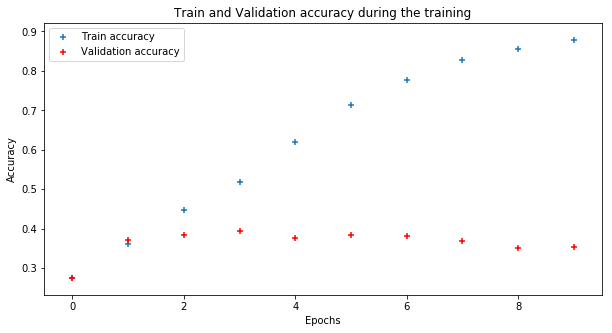

In [287]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.scatter(history.epoch, history.history['acc'], marker='+')
plt.scatter(history.epoch, history.history['val_acc'], marker='+', color='r')
plt.legend(['Train accuracy', 'Validation accuracy'])
plt.title('Train and Validation accuracy during the training')
plt.ylabel('Accuracy')
_ = plt.xlabel('Epochs')

In [270]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 64
n_epochs = 10

history = model.fit(train_sentences, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(dev_sentences, y_dev))

/Users/mnannan/.virtualenvs/supelec/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 16s 2ms/step - loss: 1.5769 - acc: 0.2725 - val_loss: 1.5668 - val_acc: 0.2543
Epoch 2/10
8544/8544 [==============================] - 11s 1ms/step - loss: 1.5121 - acc: 0.3352 - val_loss: 1.4387 - val_acc: 0.3697
Epoch 3/10
8544/8544 [==============================] - 14s 2ms/step - loss: 1.2901 - acc: 0.4338 - val_loss: 1.4038 - val_acc: 0.3742
Epoch 4/10
8544/8544 [==============================] - 14s 2ms/step - loss: 1.1050 - acc: 0.5022 - val_loss: 1.4588 - val_acc: 0.3815
Epoch 5/10
8544/8544 [==============================] - 14s 2ms/step - loss: 0.9398 - acc: 0.5872 - val_loss: 1.5670 - val_acc: 0.3760
Epoch 6/10
8544/8544 [==============================] - 15s 2ms/step - loss: 0.7909 - acc: 0.6946 - val_loss: 1.7284 - val_acc: 0.3769
Epoch 7/10
8544/8544 [==============================] - 11s 1ms/step - loss: 0.6431 - acc: 0.7635 - val_loss: 1.9284 - val_acc: 0.3733
Epoch 8

In [213]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

with open(os.path.join(PATH_TO_DATA, 'logreg_lstm_y_test_sst.txt'), 'w') as f:
    f.writelines('\n'.join(np.argmax(model.predict(test_sentences), axis=1).astype('str').tolist()))


## 4.3 -- innovate !

In [302]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.


Loaded 50000 pretrained word vectors
